<div align="center">
<h1>HEART DISEASE PREDICTION </h1>
</div>
 

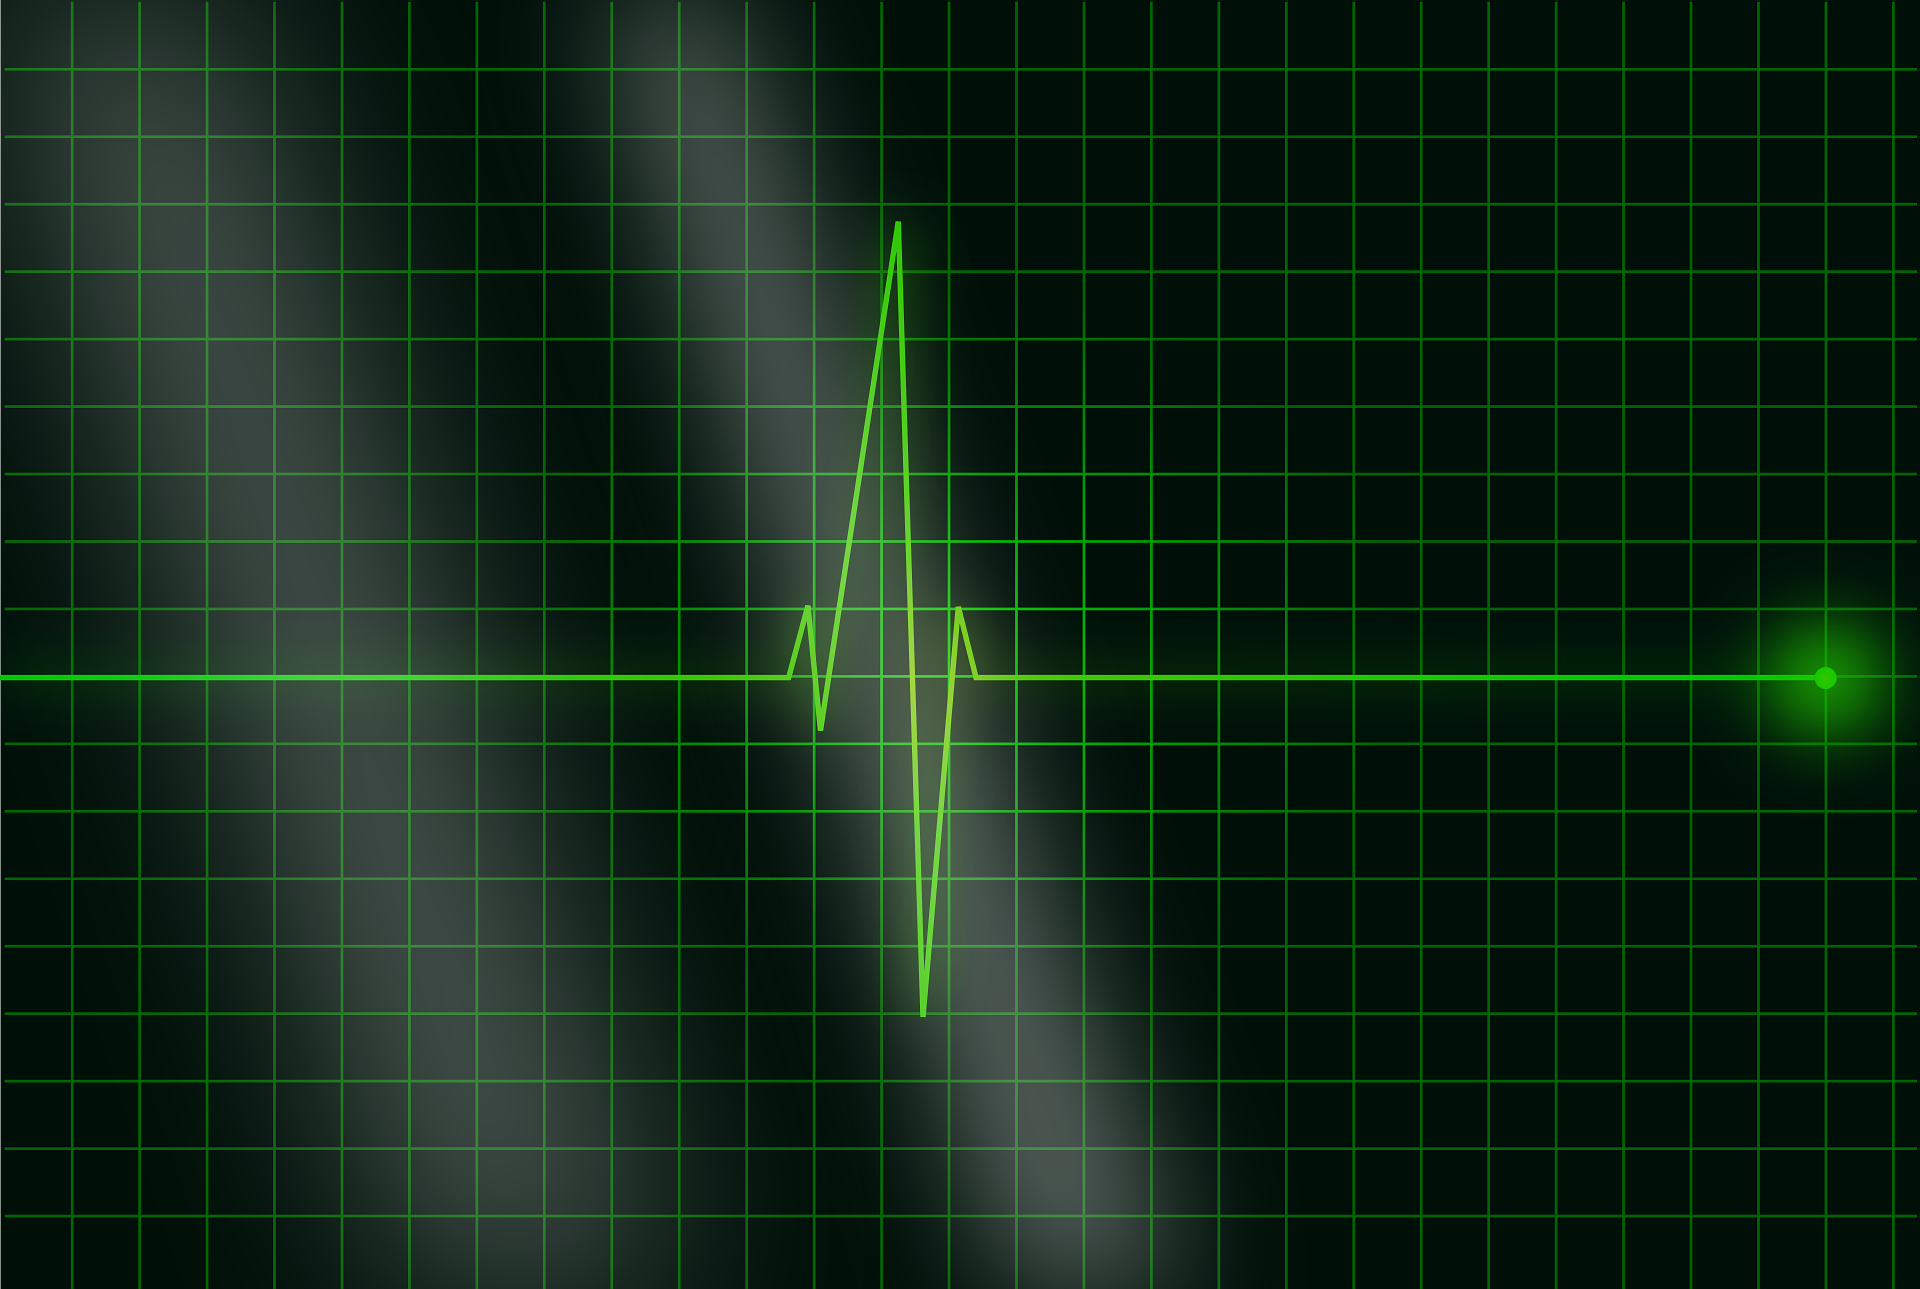


## Data Loading

In [121]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import confusion_matrix, accuracy_score

import joblib
import pickle


import warnings
warnings.filterwarnings('ignore')


In [84]:
# loading the dataset:

# load data
heart_df = pd.read_csv('Heart Disease Predictions.csv')

# creating copy of dataset
heart_df_copy= heart_df.copy()

### Data Info

In [85]:
# view the head of the datasef
heart_df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [86]:
# checking the shape
heart_df.shape

(5508, 12)

In [87]:
# get info of the dataset
heart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5508 entries, 0 to 5507
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             5508 non-null   int64  
 1   Sex             5508 non-null   object 
 2   ChestPainType   5508 non-null   object 
 3   RestingBP       5508 non-null   int64  
 4   Cholesterol     5508 non-null   int64  
 5   FastingBS       5508 non-null   int64  
 6   RestingECG      5508 non-null   object 
 7   MaxHR           5508 non-null   int64  
 8   ExerciseAngina  5508 non-null   object 
 9   Oldpeak         5508 non-null   float64
 10  ST_Slope        5508 non-null   object 
 11  HeartDisease    5508 non-null   int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 516.5+ KB


In [88]:
# summary statistics
heart_df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,5508.000000,5508.000000,5508.000000,5508.000000,5508.000000,5508.000000,5508.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.428333,18.505747,109.334476,0.422854,25.448773,1.066086,0.497188
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.000000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [89]:
# checking for the number of NaNs in each column
heart_df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

##### *The data does not contain any missing values!*

## Initial Visulaizations & EDA
* Data distributions & relationships  
    - Distribution of numerical features
    - Distribution of categorical features
* Outlier visulaization   

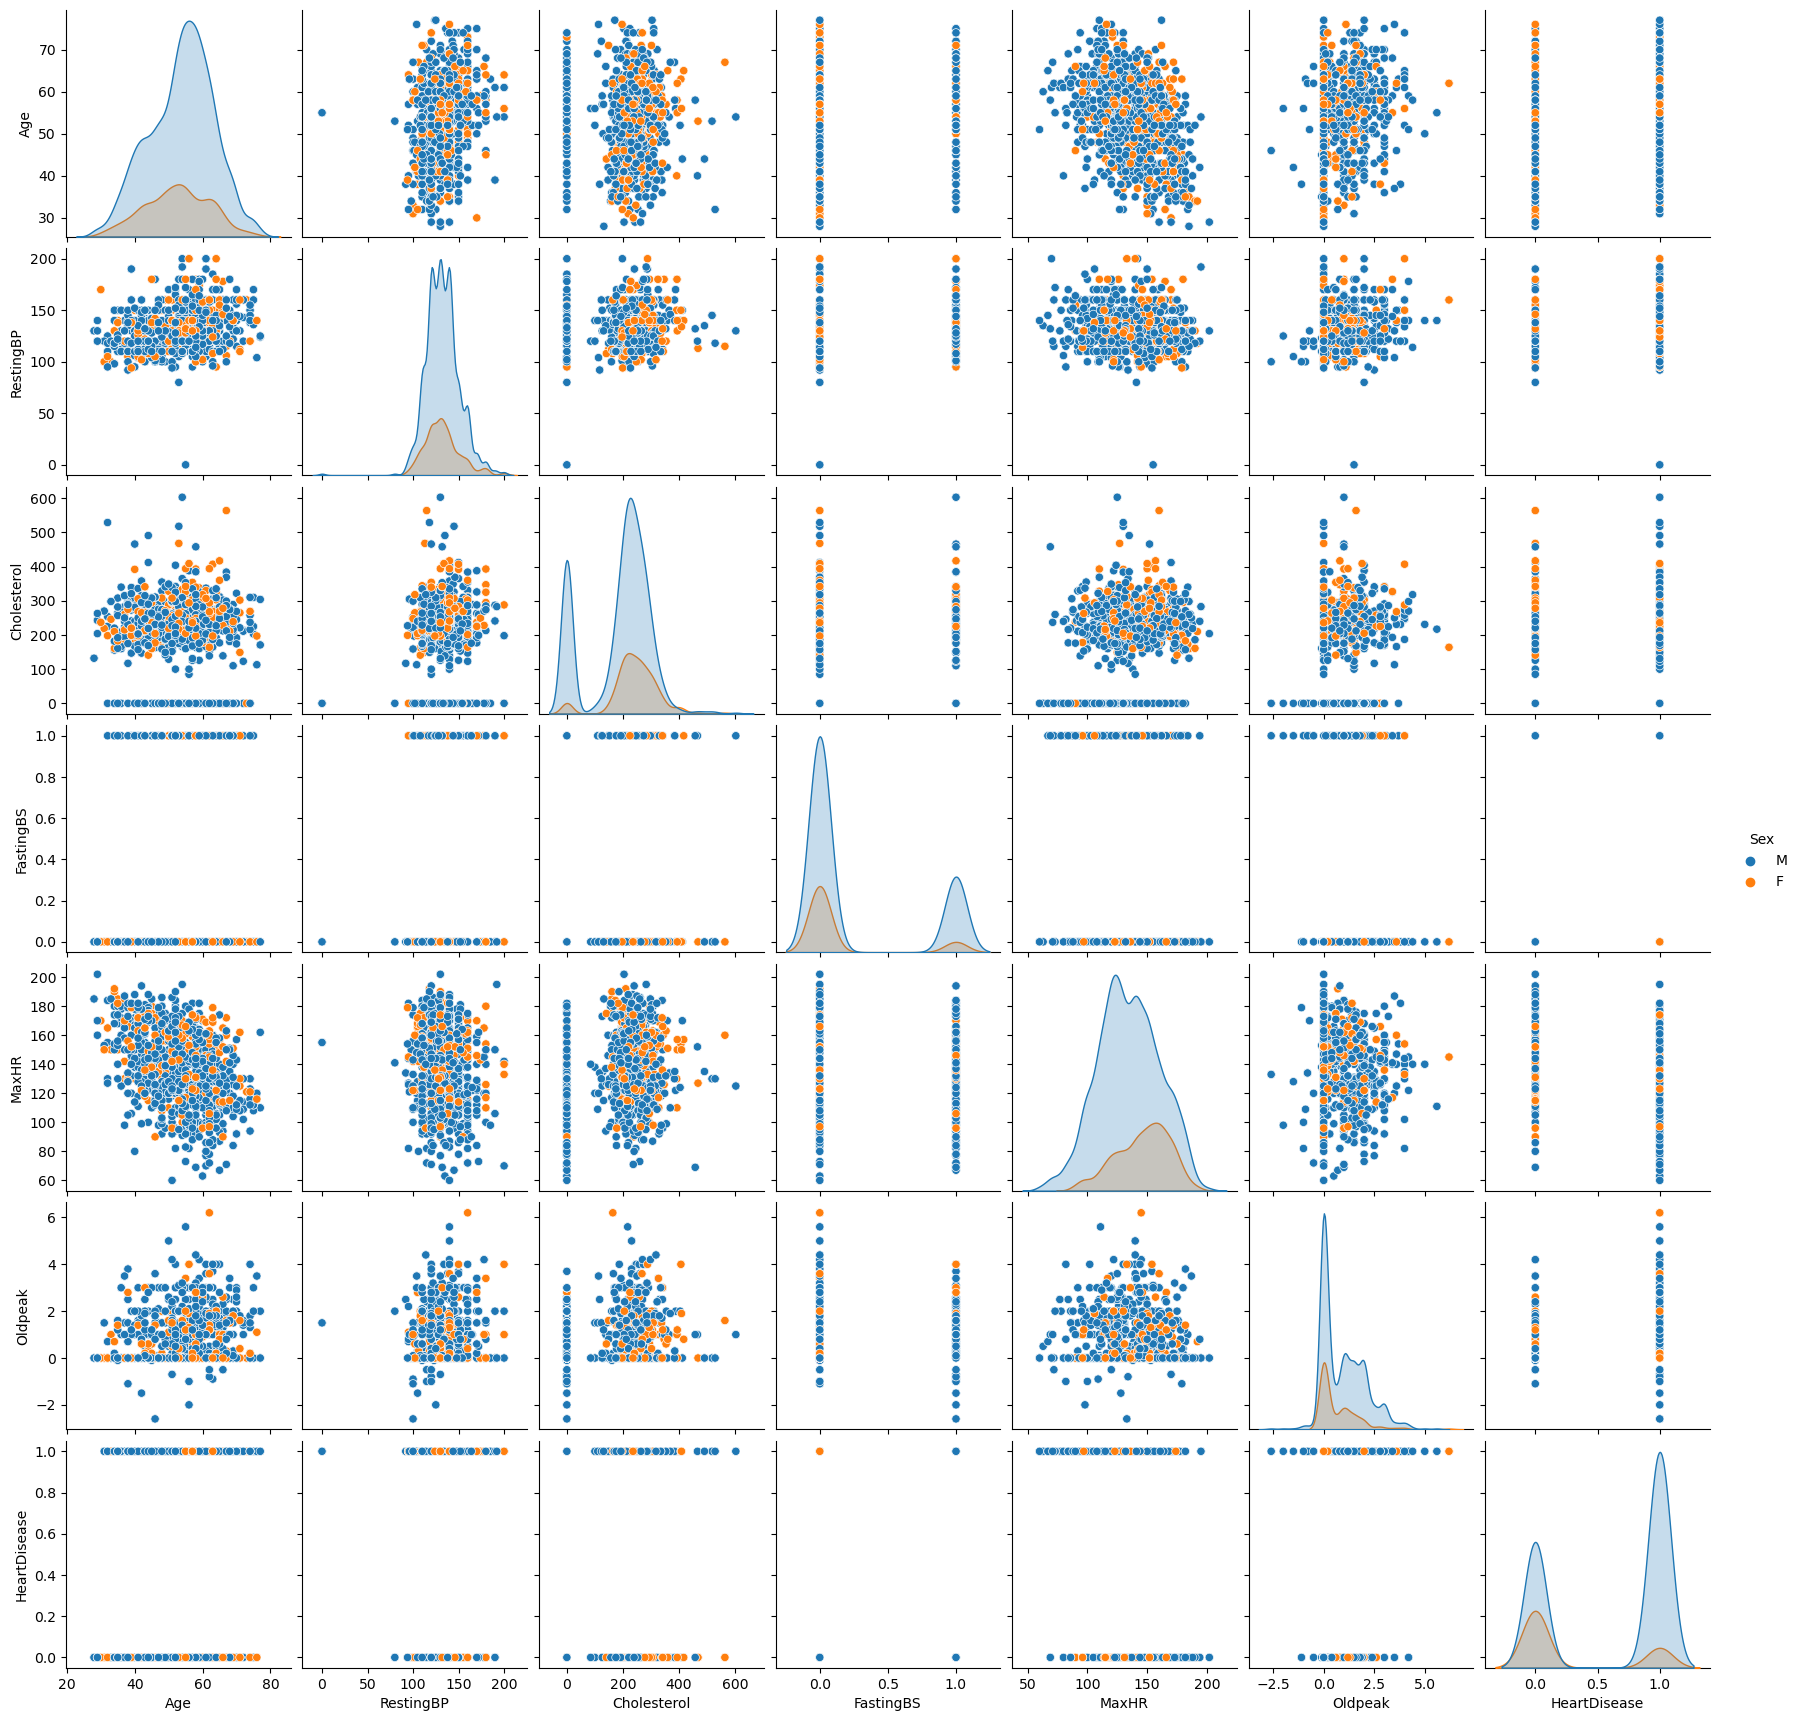

In [90]:
# Data istributions

sns.pairplot(heart_df, hue='Sex')
plt.show()


### Distribution of Numerical Features

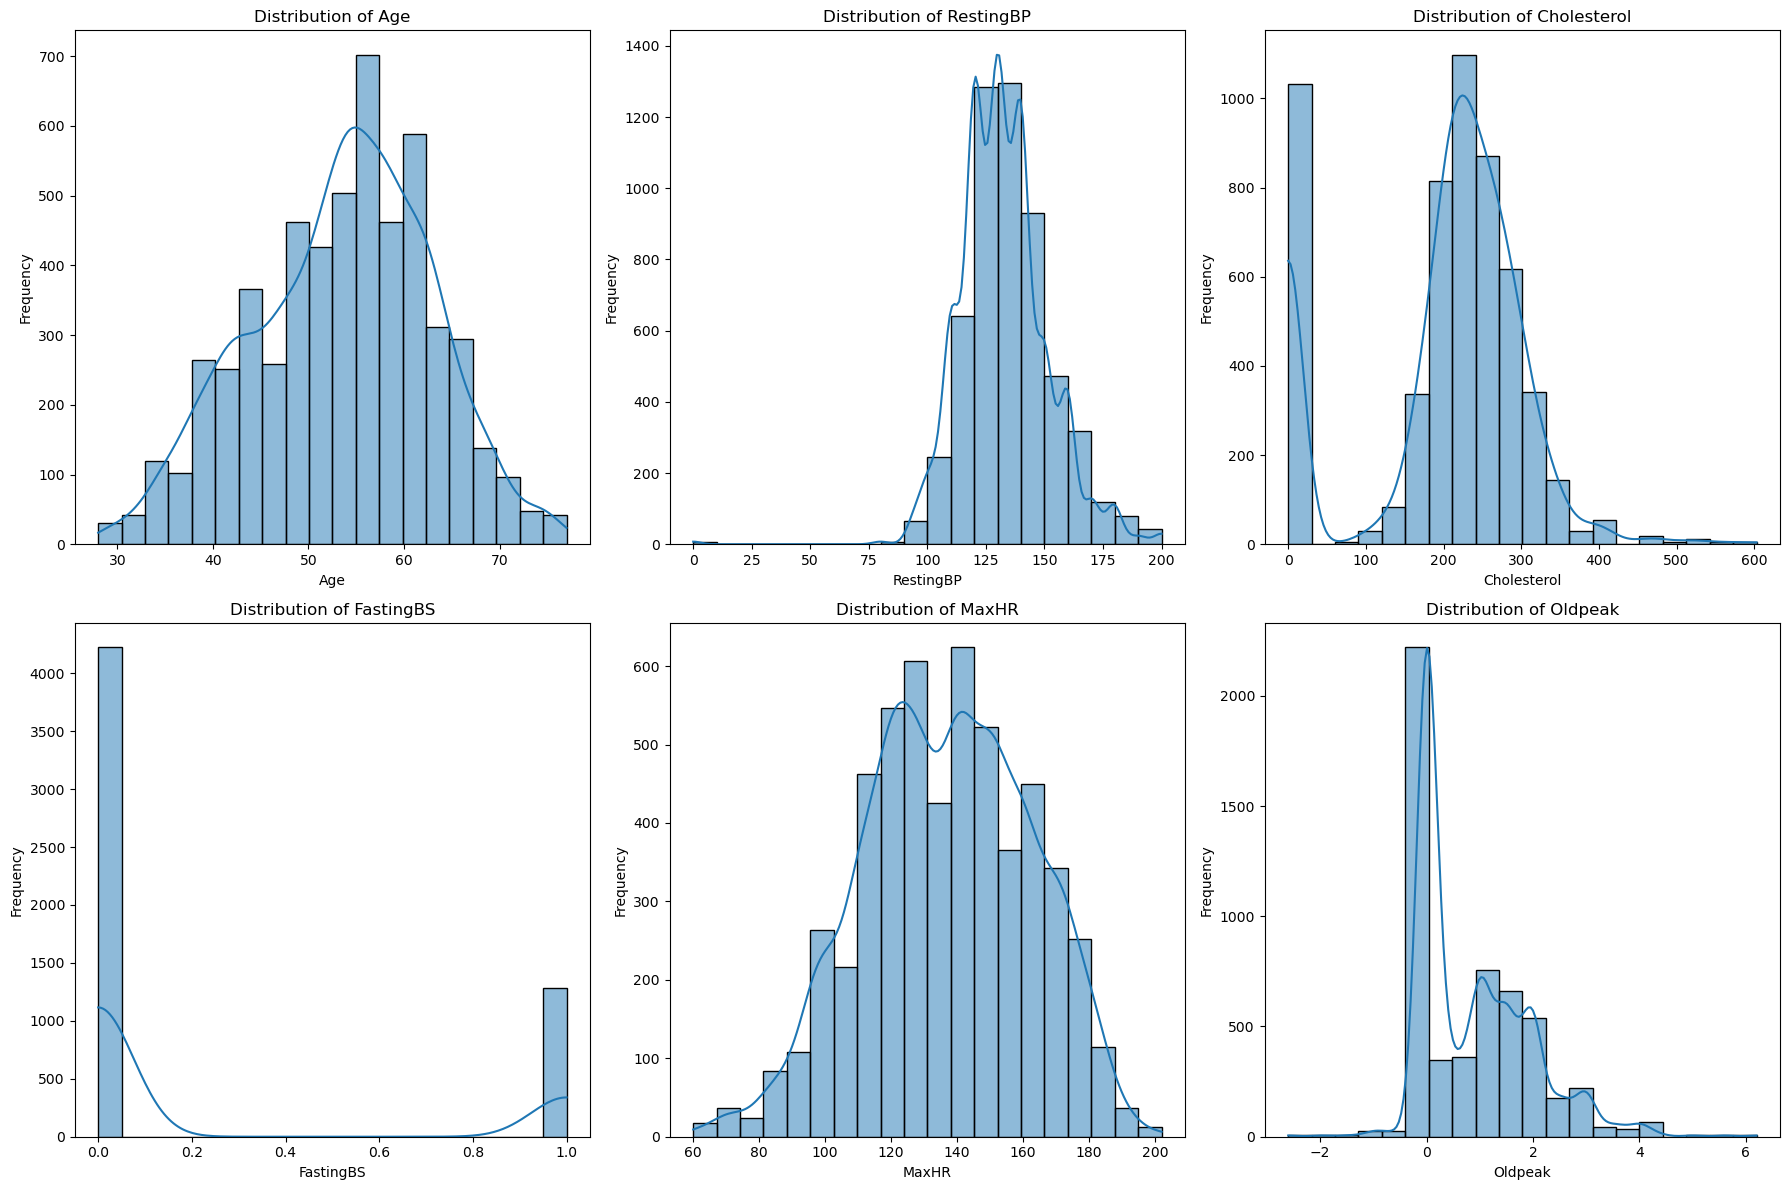

In [91]:

# List of columns to plot
columns_to_plot = ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak'   ]

# Create the figure
plt.figure(figsize=(18, 12))

# Iterate through the columns and create subplots
for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(2, 3, i)  
    sns.histplot(heart_df[column], kde=True, bins = 20)
    # plt.hist(heart_df[column], bins=20, edgecolor='black', color='y')
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


### Distribution of Categorical Features

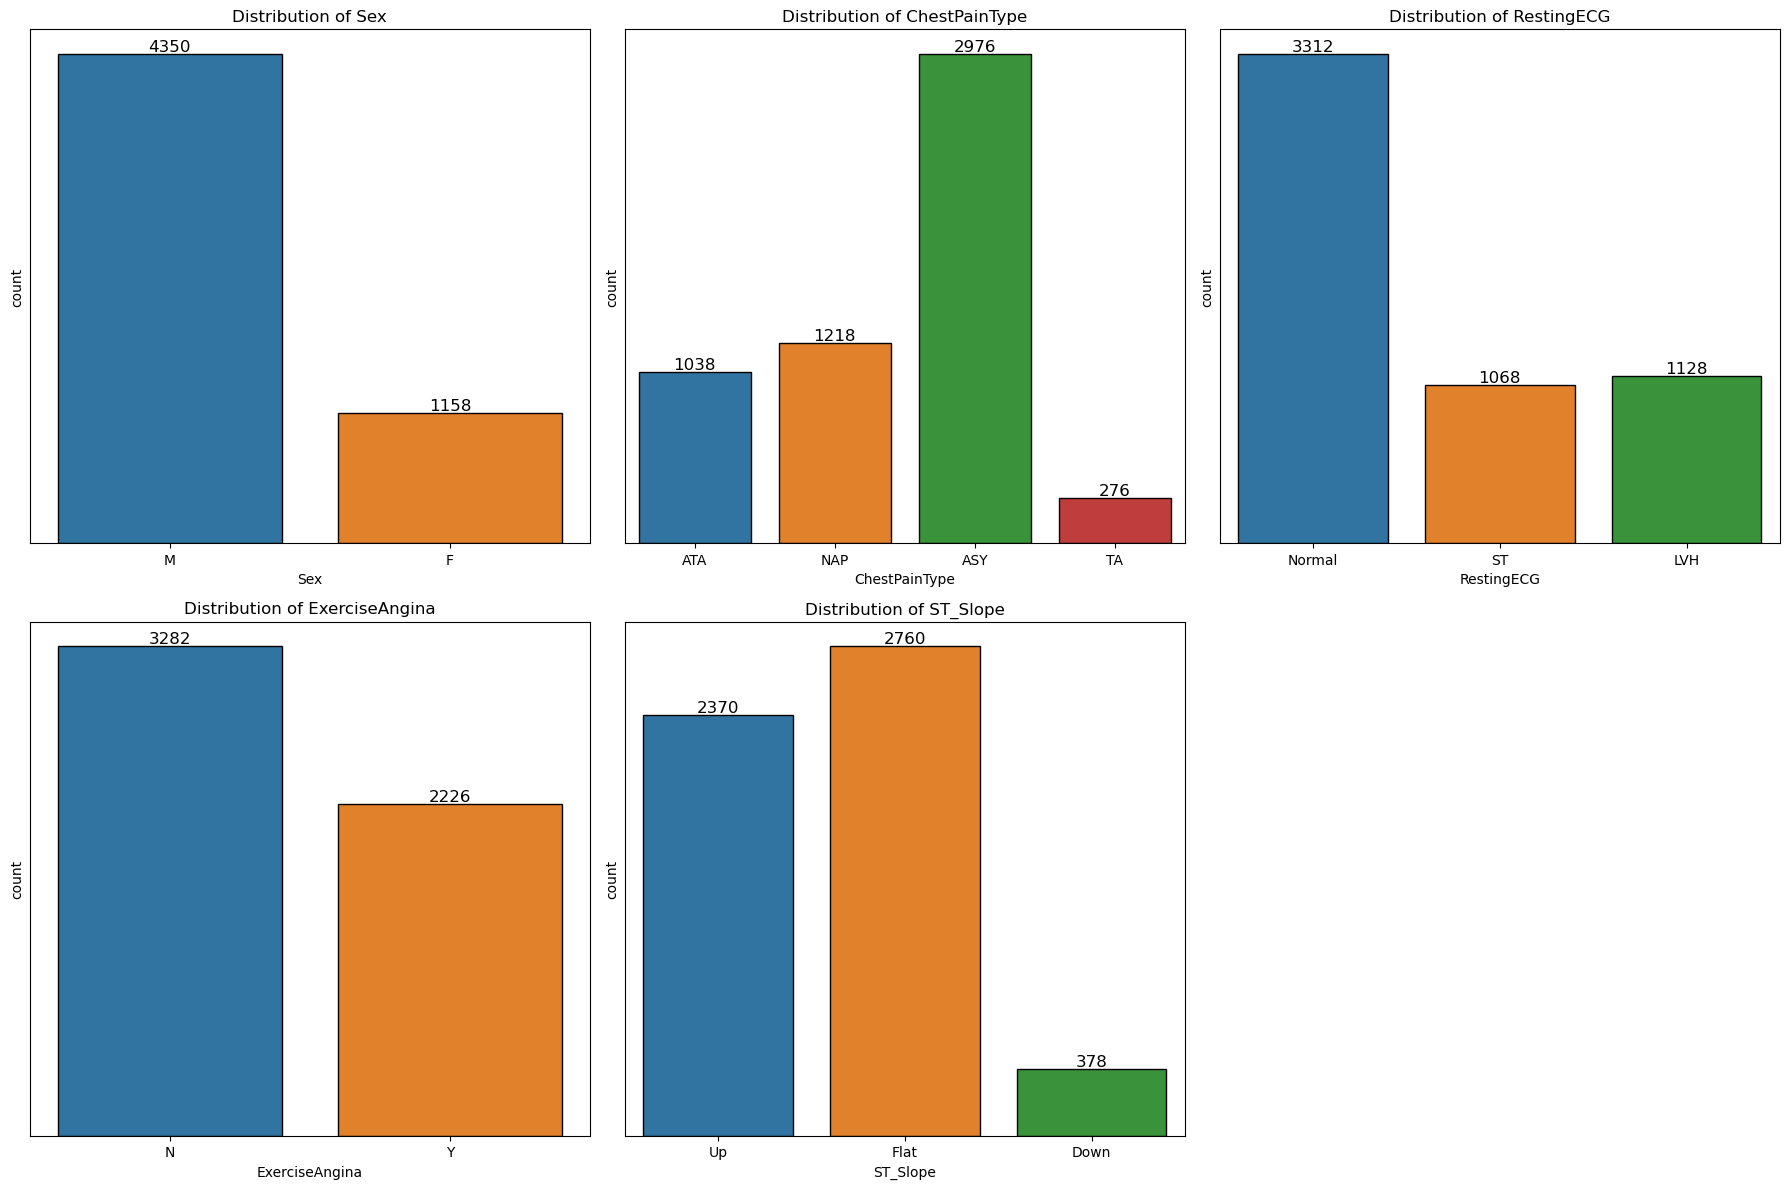

In [92]:
# List of columns to plot
categorical_columns = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

# Create the figure
plt.figure(figsize=(18, 12))

# Iterate through the columns and create subplots
for i, column in enumerate(categorical_columns, 1):
    plt.subplot(2, 3, i)  
    ax = sns.countplot(x=heart_df[column], data=heart_df, edgecolor='black')
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.yticks([])
    
    # add data labels
    ax.bar_label(ax.containers[0], label_type='edge', fontsize = 12)

plt.tight_layout()
plt.show()





### Outlier visualization  
- Boxplot

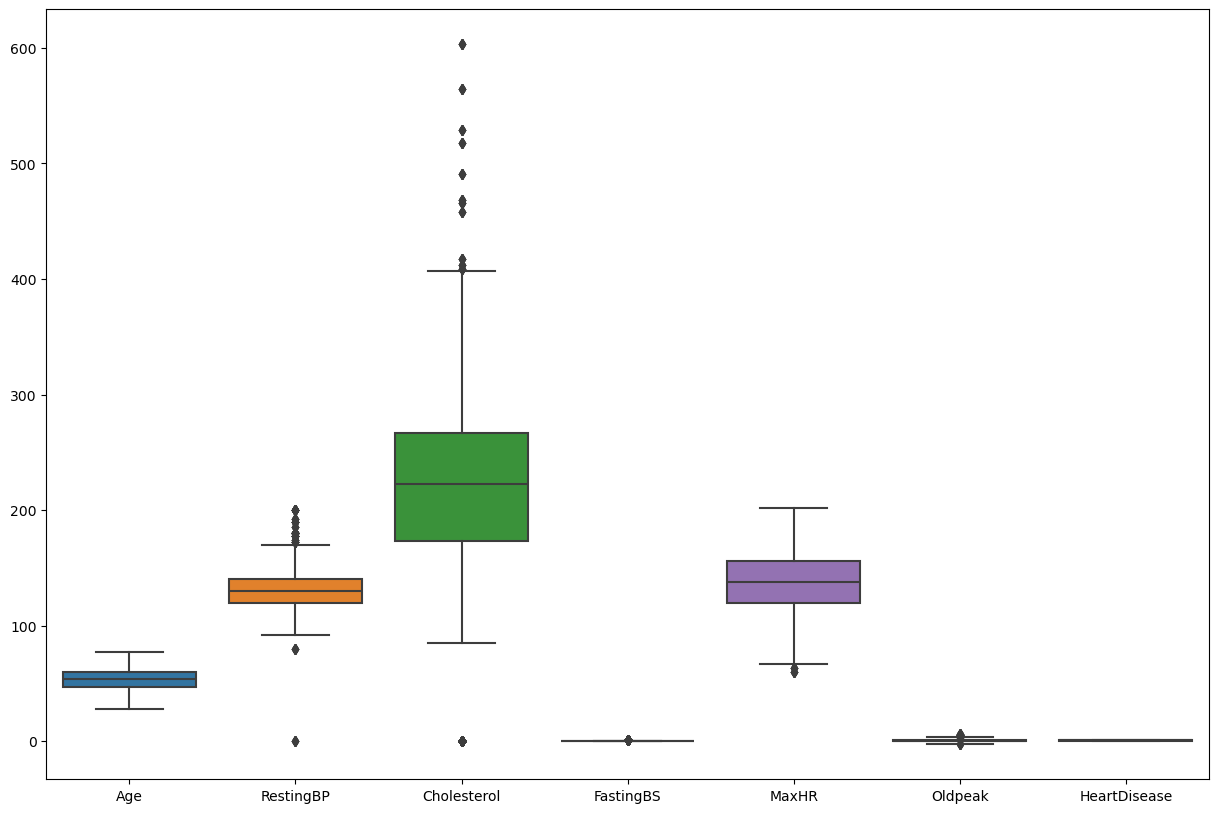

In [93]:
plt.figure(figsize=(15, 10))
sns.boxplot(data=heart_df)
plt.show()

## Data Cleaning & Preprocessing  
* Removing outliers(Scaling)
* Label Encoding
*  Handle Duplicates



### Detecting Outliers and Quantifying Them

In [95]:

# Calculate the IQR for each numerical column
def detect_outliers_iqr(df):
    outliers_dict = {}
    for col in df.select_dtypes(include=['float64', 'int']).columns:  #select the numerical columns to iterate over
        Q1 = df[col].quantile(0.25)  #calculate the first quaartile
        Q3 = df[col].quantile(0.75)  # calculate the third quartile
        IQR = Q3 - Q1  #the interquartile range
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # define the outliers 
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outliers_dict[col] = outliers
    return outliers_dict

outliers_dict = detect_outliers_iqr(heart_df)

# qualtifying the outliers

total_outliers = sum(len(outliers) for outliers in outliers_dict.values())
total_data_points = len(heart_df)
percentage_outliers = (total_outliers / total_data_points) * 100

print(f'Percentage of outliers: {percentage_outliers:.2f}%')


Percentage of outliers: 48.26%


In [103]:
# removing outliers

def remove_outliers(df):
    for col in df.select_dtypes(include=['float64', 'int64']).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

heart_df_cleaned = remove_outliers(heart_df)
heart_df_cleaned.shape

(3528, 12)

#### Label Encoding

In [104]:
# using label encoder
le = LabelEncoder()

# apply labe encoder for each categorical column
for col in heart_df_cleaned.select_dtypes(include=['object']).columns:
    heart_df_cleaned[col] = le.fit_transform(heart_df_cleaned[col])

In [105]:
heart_df_cleaned.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140,289,0,1,172,0,0.0,2,0
1,49,0,2,160,180,0,1,156,0,1.0,1,1
2,37,1,1,130,283,0,2,98,0,0.0,2,0
3,48,0,0,138,214,0,1,108,1,1.5,1,1
4,54,1,2,150,195,0,1,122,0,0.0,2,0


In [107]:
# checking the data types
print(heart_df_cleaned.info())

<class 'pandas.core.frame.DataFrame'>
Index: 3528 entries, 0 to 5507
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             3528 non-null   int64  
 1   Sex             3528 non-null   int32  
 2   ChestPainType   3528 non-null   int32  
 3   RestingBP       3528 non-null   int64  
 4   Cholesterol     3528 non-null   int64  
 5   FastingBS       3528 non-null   int64  
 6   RestingECG      3528 non-null   int32  
 7   MaxHR           3528 non-null   int64  
 8   ExerciseAngina  3528 non-null   int32  
 9   Oldpeak         3528 non-null   float64
 10  ST_Slope        3528 non-null   int32  
 11  HeartDisease    3528 non-null   int64  
dtypes: float64(1), int32(5), int64(6)
memory usage: 289.4 KB
None


#### Handling Duplicates

In [108]:
# checking for duplicates
heart_df_cleaned[heart_df_cleaned.duplicated()]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
918,40,1,1,140,289,0,1,172,0,0.0,2,0
919,49,0,2,160,180,0,1,156,0,1.0,1,1
920,37,1,1,130,283,0,2,98,0,0.0,2,0
921,48,0,0,138,214,0,1,108,1,1.5,1,1
922,54,1,2,150,195,0,1,122,0,0.0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
5502,57,0,0,140,241,0,1,123,1,0.2,1,1
5503,45,1,3,110,264,0,1,132,0,1.2,1,1
5505,57,1,0,130,131,0,1,115,1,1.2,1,1
5506,57,0,1,130,236,0,0,174,0,0.0,1,1


In [109]:
# removing teh duplicates
clean_heart_df = heart_df_cleaned.drop_duplicates()

# check the new shape 
clean_heart_df.shape

(588, 12)

**Dropping duplicates leaves us with 918 rows for model training and evaluation**

**Removing the duplicates has the potential to heavily impact the study and the models to be used.  
This is due to the fact that the dupicates take up more than half of the dataset. 
Secondly, there are no patient ID, for us to determine whether or not theses inputs are real-life duplicates.  
In addition, since there will be data splitting into train and test sets, shall we keep the duplicates and access how the model performs?**



## Model Selection  
*Models to consider...*

- Logistic Regression
- Decision Tree
- Random Forest
- XG Boost


In [111]:
# define features and traget:

x = clean_heart_df.drop('HeartDisease', axis=1)  #select from the dataframe, all columns where dataype is int64
y = clean_heart_df['HeartDisease']

# splitting the data into train and test data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = 42)

**Logistic Regression**

Logistic Regression accuracy: 0.8728813559322034
Confusion Matrix:
[[63  5]
 [10 40]]


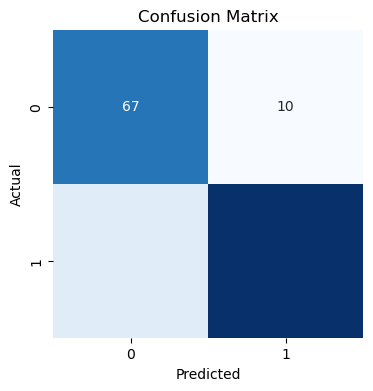

In [112]:
# build and train the logistic regression model
logReg = LogisticRegression()
logReg.fit(x_train, y_train) 

# make predictions
y_pred = logReg.predict(x_test)

# evulate the model
logReg_accuracy = accuracy_score(y_test, y_pred)
logReg_conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Logistic Regression accuracy: {logReg_accuracy}")
print(f"Confusion Matrix:\n{logReg_conf_matrix}")

# -------------------------------------

# Plot confusion matrix
plt.figure(figsize=(4, 4))
sns.heatmap(logistic_model_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

**Decision Tree**

Decision Tree accuracy: 0.8220338983050848
Confusion Matrix:
[[61  7]
 [14 36]]


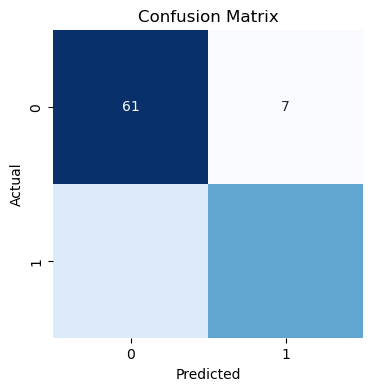

In [113]:
# create the classifier
dec_tree = DecisionTreeClassifier(random_state=42)

# train the tree classifier
dec_tree.fit(x_train, y_train)

# make predictions
tree_preds = dec_tree.predict(x_test)

# evaluate the tree
tree_accuracy = accuracy_score(y_test, tree_preds)
tree_conf_matrix = confusion_matrix(y_test, tree_preds)

print(f"Decision Tree accuracy: {tree_accuracy}")
print(f"Confusion Matrix:\n{tree_conf_matrix}")

#-------------------------------------------
# Plot confusion matrix
plt.figure(figsize=(4, 4))
sns.heatmap(tree_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


**Random Forest Classifier**

Random Forest Accuracy: 0.9067796610169492
Confusion Matrix:
[[64  4]
 [ 7 43]]


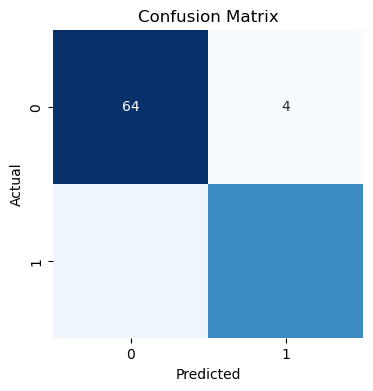

In [138]:
# instantiate the model
random_forest = RandomForestClassifier()

# fit the model
random_forest.fit(x_train, y_train)

# make predctions
rf_preds = random_forest.predict(x_test)

# evaluation of model
rf_accuracy = accuracy_score(y_test, rf_preds)
print(f'Random Forest Accuracy: {rf_accuracy}')

# confusion matrix
rf_conf_matrix = confusion_matrix(y_test, rf_preds)
print(f"Confusion Matrix:\n{rf_conf_matrix}")

plt.figure(figsize=(4, 4))
sns.heatmap(rf_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, )
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

XGBoost Accuracy: 0.8813559322033898
Confusion Matrix:
[[61  7]
 [ 7 43]]


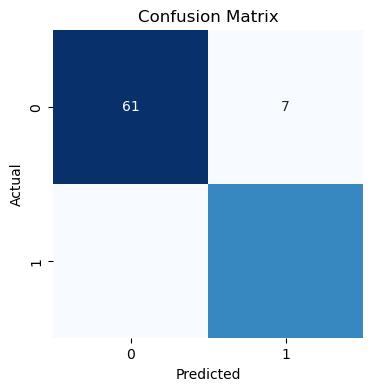

In [133]:
# XG Boost Classification
xgb_model = xgb.XGBClassifier(objective='binary:logistic')

# fit the model
xgb_model.fit(x_train, y_train)

# make predictions
xgb_preds = xgb_model.predict(x_test)

# model evaluation
xgb_accuracy = accuracy_score(y_test, xgb_preds)
print(f'XGBoost Accuracy: {xgb_accuracy}')

# confusion matrix
xgb_conf_matrix = confusion_matrix(y_test, xgb_preds)
print(f"Confusion Matrix:\n{xgb_conf_matrix}")

plt.figure(figsize=(4, 4))
sns.heatmap(xgb_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, )
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Conclusion
*After training and evaluating the four models under consideration, the **Random Forest Classifier** turns out to be the best performing model with an accuracy of 0.9067*  

### Up Next: efforts to improve
- scaling/normalization
- PCA